In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
paths = []
labels = []

for dirname, _, filenames in os.walk('TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        labels.append(filename.split('_')[-1].split('.')[0].lower())

print('TESS (Toronto emotional speech set data) successfully loaded!')

TESS (Toronto emotional speech set data) successfully loaded!


In [4]:
paths[:5]

['TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [5]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [6]:
df = pd.DataFrame()
df['audio'] = paths
df['label'] = labels

In [7]:
df.head()

,audio,label
0,TESS Toronto emotional speech set data\OAF_ang...,angry
1,TESS Toronto emotional speech set data\OAF_ang...,angry
2,TESS Toronto emotional speech set data\OAF_ang...,angry
3,TESS Toronto emotional speech set data\OAF_ang...,angry
4,TESS Toronto emotional speech set data\OAF_ang...,angry


In [8]:
df['label'].value_counts()

label
angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: count, dtype: int64

## Exploaratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

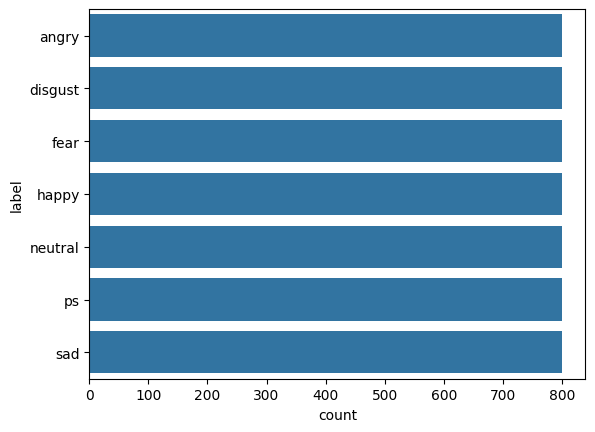

In [9]:
sns.countplot(df['label'])

In [10]:
import librosa.display

def waveplot(audio, sr, emotion):
    plt.figure(figsize = (9,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(audio, sr=sr, color="blue")
    plt.show()


def spectogram(audio, sr, emotion):
    x = librosa.stft(audio)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize = (9.3,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis = 'time', y_axis = 'hz')
    plt.colorbar()

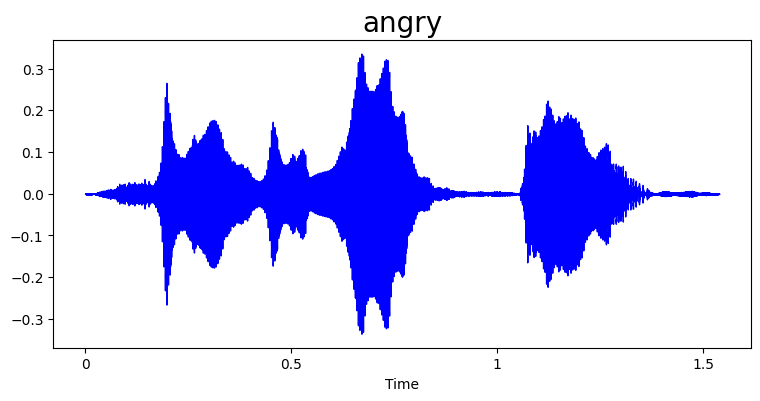

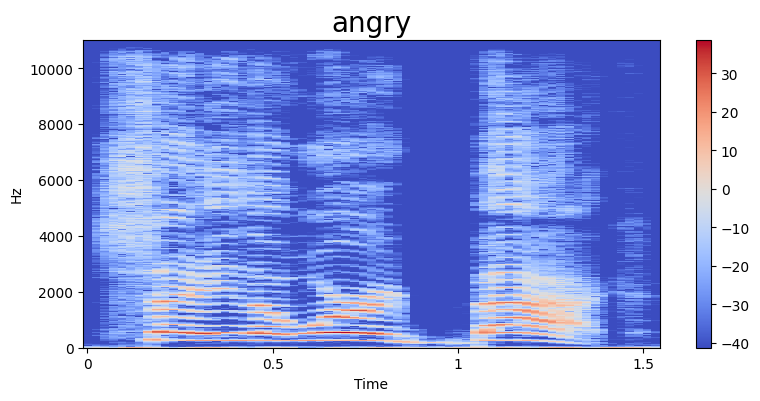

In [11]:
emotion = 'angry'
path = np.array(df['audio'][df['label']==emotion])[0]
audio, sampling_rate = librosa.load(path)
waveplot(audio, sampling_rate, emotion)
spectogram(audio, sampling_rate, emotion)

In [12]:
Audio(path)

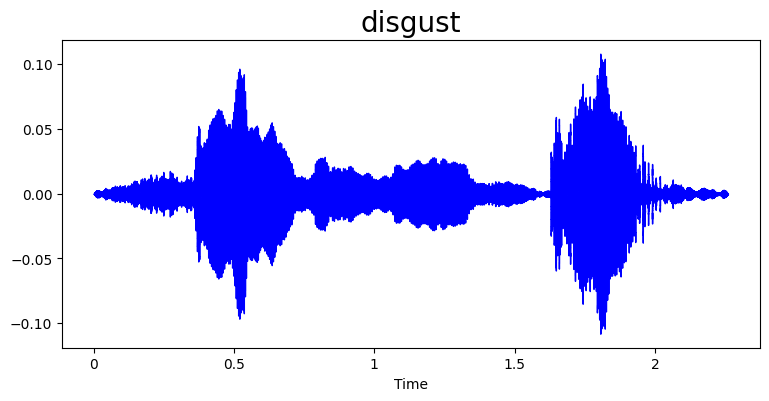

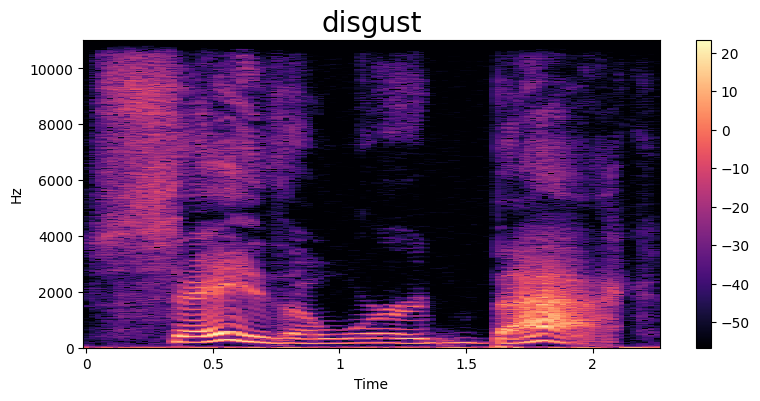

In [13]:
emotion = 'disgust'
path = np.array(df['audio'][df['label']==emotion])[0]
audio, sampling_rate = librosa.load(path)
waveplot(audio, sampling_rate, emotion)
spectogram(audio, sampling_rate, emotion)
Audio(path)

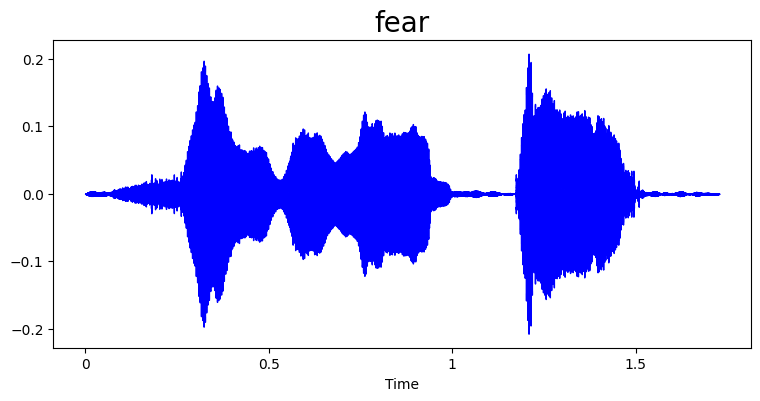

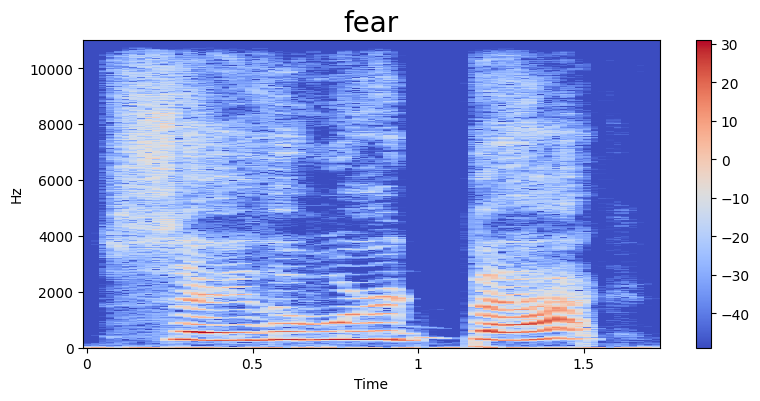

In [14]:
emotion = 'fear'
path = np.array(df['audio'][df['label']==emotion])[0]
audio, sampling_rate = librosa.load(path)
waveplot(audio, sampling_rate, emotion)
spectogram(audio, sampling_rate, emotion)
Audio(path)

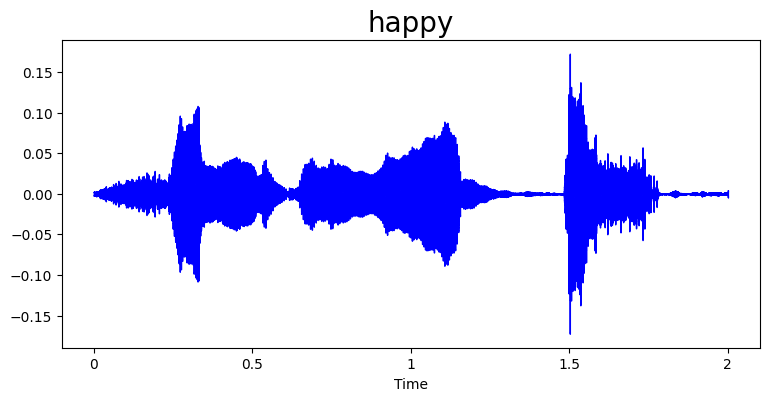

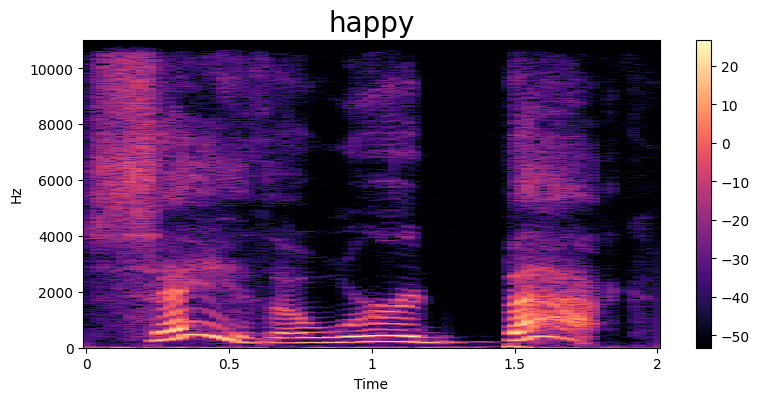

In [15]:
emotion = 'happy'
path = np.array(df['audio'][df['label']==emotion])[0]
audio, sampling_rate = librosa.load(path)
waveplot(audio, sampling_rate, emotion)
spectogram(audio, sampling_rate, emotion)
Audio(path)

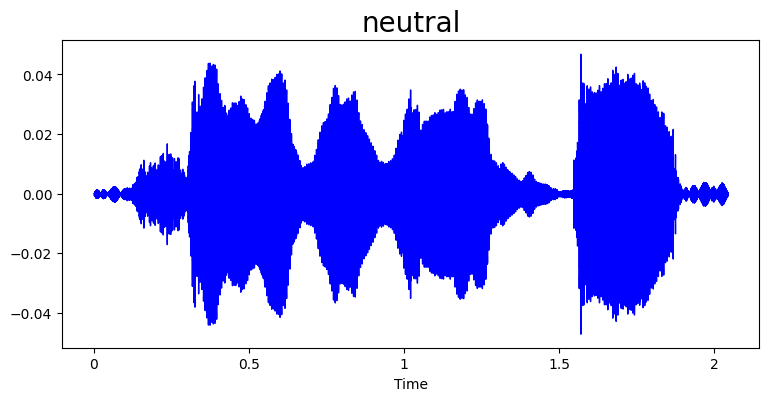

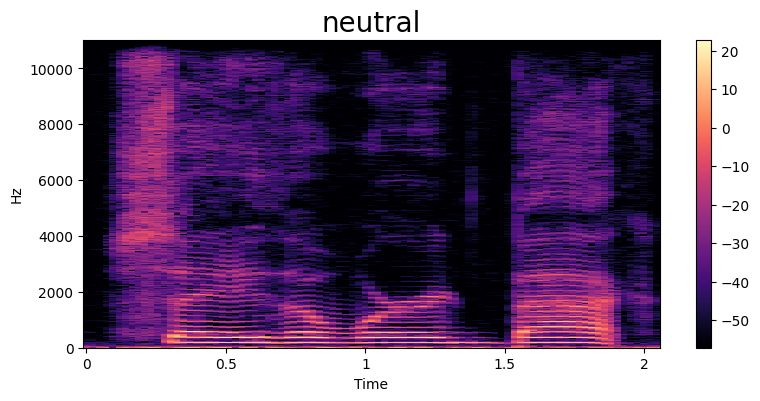

In [16]:
emotion = 'neutral'
path = np.array(df['audio'][df['label']==emotion])[0]
audio, sampling_rate = librosa.load(path)
waveplot(audio, sampling_rate, emotion)
spectogram(audio, sampling_rate, emotion)
Audio(path)

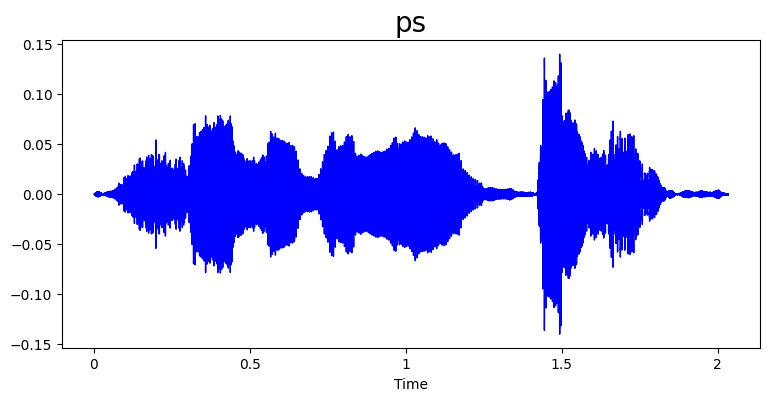

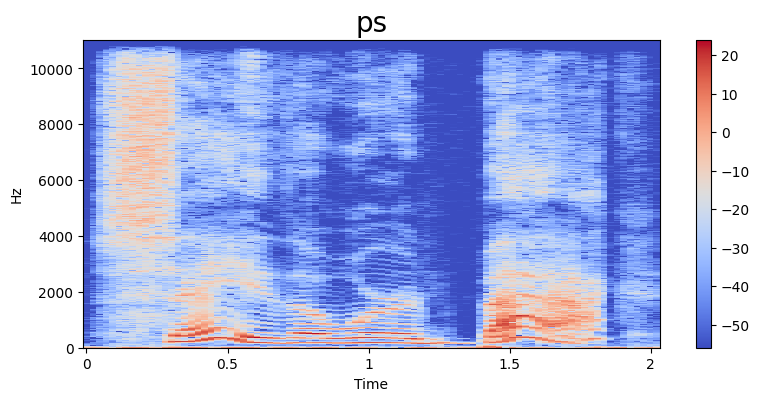

In [17]:
emotion = 'ps'
path = np.array(df['audio'][df['label']==emotion])[0]
audio, sampling_rate = librosa.load(path)
waveplot(audio, sampling_rate, emotion)
spectogram(audio, sampling_rate, emotion)
Audio(path)

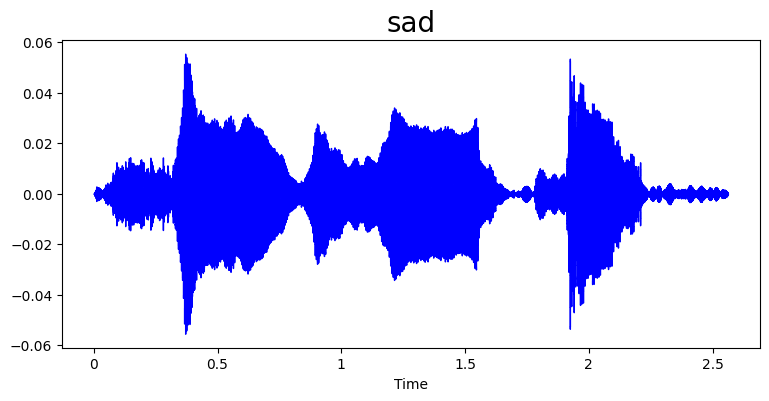

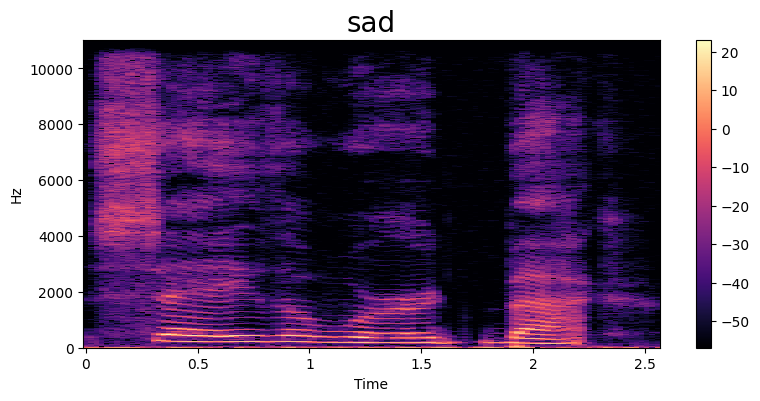

In [18]:
emotion = 'sad'
path = np.array(df['audio'][df['label']==emotion])[0]
audio, sampling_rate = librosa.load(path)
waveplot(audio, sampling_rate, emotion)
spectogram(audio, sampling_rate, emotion)
Audio(path)

## Feature Extraction

In [19]:
def extract_mfcc(filename):
    # Mel-Frequency Cepstral Coefficients
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [20]:
extract_mfcc(df['audio'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275578e+00,  1.00753632e+01, -2.03667068e+01, -6.09245014e+00,
       -7.21228313e+00, -5.57365894e-01, -1.83255363e+00,  2.02101767e-01,
        7.27550745e-01,  1.31773770e+00,  2.88633752e+00,  2.85579133e+00,
       -4.71292162e+00, -4.43651104e+00, -1.62115932e+00, -1.02398405e+01,
       -7.55126143e+00, -1.79688025e+00, -7.03765202e+00,  9.43658447e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169895e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722819e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996351e+00, -1.82390726e+00,
        4.86896276e+00,  9.31392288e+00,  2.08915043e+00, -1.90649104e+00],
      dtype=float32)

In [21]:
X_mfcc = df['audio'].apply(lambda x: extract_mfcc(x))

In [22]:
X_mfcc

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.65600884, -32.74544, ...
2       [-429.79196, 46.124, 1.5550473, -0.21709493, 2...
3       [-403.46118, 76.32369, -12.531774, -22.288858,...
4       [-434.05756, 77.4455, 10.8655, 16.092943, 8.04...
                              ...                        
5595    [-406.48053, 80.379875, 32.462395, 46.579094, ...
5596    [-426.90918, 102.54757, 24.800041, 43.048096, ...
5597    [-378.50494, 80.91062, 35.300533, 39.74792, -4...
5598    [-434.8618, 89.90637, 28.373262, 39.57707, -2....
5599    [-421.8341, 70.69788, 32.476387, 45.642555, 4....
Name: audio, Length: 5600, dtype: object

In [31]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [32]:
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [37]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [47]:
y = y.toarray()

In [42]:
y.shape

(5600, 7)

## Creating the LSTM Model

In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(128, return_sequences = False, input_shape = (40,1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(7, activation = 'softmax')
])

model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 77127 (301.28 KB)
Trainable params: 771

In [48]:
history = model.fit(X,y, validation_split=0.2, epochs = 100, batch_size=512, shuffle=True)


Epoch 1/100


9/9 [==============================] - 6s 276ms/step - loss: 1.8641 - accuracy: 0.2283 - val_loss: 1.8304 - val_accuracy: 0.2482
Epoch 2/100
9/9 [==============================] - 2s 182ms/step - loss: 1.6173 - accuracy: 0.4384 - val_loss: 1.6111 - val_accuracy: 0.3616
Epoch 3/100
9/9 [==============================] - 2s 181ms/step - loss: 1.3051 - accuracy: 0.5342 - val_loss: 1.2481 - val_accuracy: 0.4839
Epoch 4/100
9/9 [==============================] - 2s 210ms/step - loss: 0.9989 - accuracy: 0.6279 - val_loss: 0.8776 - val_accuracy: 0.6089
Epoch 5/100
9/9 [==============================] - 2s 186ms/step - loss: 0.7593 - accuracy: 0.7266 - val_loss: 0.5830 - val_accuracy: 0.7955
Epoch 6/100
9/9 [==============================] - 2s 202ms/step - loss: 0.5814 - accuracy: 0.7931 - val_loss: 0.4037 - val_accuracy: 0.8750
Epoch 7/100
9/9 [==============================] - 2s 198ms/step - loss: 0.4860 - accuracy: 0.8286 - val_loss: 0.3071 - val_accuracy: 0.9152
Epoch 8/100

## Plotting the results

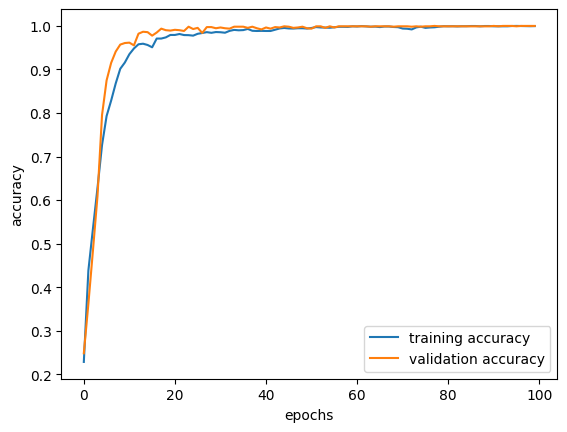

In [51]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

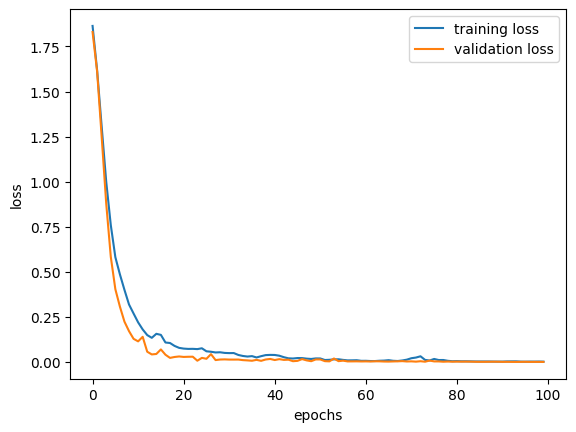

In [53]:
epochs = list(range(100))
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()